In [151]:
#!/usr/bin/env python3
# Multi-band LFP + multi-unit spikes: 5 latent bands in LFP; each unit couples to 3/5 bands.

from __future__ import annotations
import os, sys, math, pathlib
import numpy as np
import matplotlib.pyplot as plt
import mne

# --- Repo paths ---
cwd_parent  = str(pathlib.Path(os.getcwd()).parent)
root_parent = str(pathlib.Path(os.getcwd()).parent.parent)
for p in (cwd_parent, root_parent):
    if p not in sys.path:
        sys.path.insert(0, p)
# --- Project imports (pure-NumPy parts; avoid early JAX) ---
from src.utils_multitaper import derotate_tfr
from src.priors import gamma_prior_simple
from src.generate_data import generate_spikes_from_latent
from src.plots import plot_lfp_and_spikes, plot_band_realparts
import pickle

# load all data 
with open("all_data.pkl", "rb") as f:
    all_data = pickle.load(f)

# read in all data 
seed = all_data["seed"]
rng = all_data["rng"]
spikes_units = all_data["spikes_units"]
Z_til_real_units = all_data["Z_til_real_units"]
Z_bar_units = all_data["Z_bar_units"]
band_masks = all_data["band_masks"]
beta_units = all_data["beta_units"]
gamma_true = all_data["gamma_true"]
lambda_true = all_data["lambda_true"]
sigma_v_true = all_data["sigma_v_true"]
sigma_eps_true = all_data["sigma_eps_true"]
freqs_hz = all_data["freqs_hz"]
freqs = all_data["freqs"]
Z_true = all_data["Z_true"]
Z_noisy = all_data["Z_noisy"]
Z_true_all = all_data["Z_true_all"]
lfp = all_data["lfp"]
filtered_signal = all_data["filtered_signal"]
tfr_raw = all_data["tfr_raw"]
tfr = all_data["tfr"]
tfr_ds = all_data["tfr_ds"]
tfr_time_ds = all_data["tfr_time_ds"]   
n_units = all_data["n_units"]
delta_spk = all_data["delta_spk"]
n_lags = all_data["n_lags"]
t_fine = all_data["t_fine"]
duration_sec = all_data["duration_sec"]
fs = all_data["fs"]
dt = 1/fs
dt_spk =delta_spk
# ---------------- Config ----------------
freqs_eval = np.arange(1, 51)         # evaluate at integer Hz 1..60
fmin       = float(freqs_eval.min())
n_shuff    = 500                      # # surrogates
win_sec    = max(2.0, 3.0 / fmin)     # Welch window; ≥3 cycles at fmin
rng_coh    = np.random.default_rng(123)
time         = np.arange(0, duration_sec, dt)
# ------------- Time bases --------------
fs_spk  = 1.0 / dt_spk
T       = len(t_fine)


In [152]:
# ================= Spike–Field Coherence (SFC) 1–60 Hz + Significance + Ground Truth =================
# Requires: lfp, time, spikes_units, t_fine, beta_units, freqs_hz

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import coherence, get_window  # ← use coherence
duration_sec = all_data["duration_sec"]
fs = all_data["fs"]
dt = 1/fs
dt_spk =delta_spk
# ---------------- Config ----------------
freqs_eval = np.arange(1, 51)         # evaluate at integer Hz 1..60
fmin       = float(freqs_eval.min())
n_shuff    = 500                      # # surrogates
win_sec    = max(2.0, 3.0 / fmin)     # Welch window; ≥3 cycles at fmin
rng_coh    = np.random.default_rng(123)
time         = np.arange(0, duration_sec, dt)
# ------------- Time bases --------------
fs_spk  = 1.0 / dt_spk
T       = len(t_fine)

# Put LFP on spike grid
lfp_on_spk = np.interp(t_fine, time, lfp).astype(float)

# ------------- Welch / CSD (kept windowing configuration) -------------
nperseg  = int(round(win_sec * fs_spk))
nperseg  = max(256, min(nperseg, T))          # clamp
noverlap = nperseg // 2
window   = get_window("hann", nperseg, fftbins=True)

def zscore(a: np.ndarray) -> np.ndarray:
    a = np.asarray(a, float)
    s = a.std()
    return (a - a.mean()) / (s if s > 0 else 1.0)

def coherence_at_freqs(x, y, fs, freqs_eval):
    """
    NEW: compute magnitude-squared coherence via scipy.signal.coherence
    and interpolate onto the requested integer frequency grid.
    """
    # Use the same window/nperseg/noverlap settings as above to preserve plots
    f, Cxy = coherence(
        x, y, fs=fs,
        window=window, nperseg=nperseg, noverlap=noverlap,
        detrend="constant"
    )
    if len(f) < 2:
        return np.zeros_like(freqs_eval, dtype=float)

    # Interpolate coherence onto integer Hz (1..60) just like before
    C_i = np.interp(freqs_eval, f, Cxy, left=np.nan, right=np.nan)
    C_i = np.where(np.isfinite(C_i), C_i, 0.0)
    C_i = np.clip(C_i, 0.0, 1.0)
    return C_i.astype(float)

# ------------- Observed SFC -------------
n_units = int(spikes_units.shape[0])
coh_obs = np.zeros((n_units, len(freqs_eval)), float)

x_base = zscore(lfp_on_spk)
for u in range(n_units):
    y = zscore(spikes_units[u].astype(float))
    coh_obs[u] = coherence_at_freqs(x_base, y, fs_spk, freqs_eval)

# ------------- Surrogates (circular shift, guarded) -------------
guard_sec  = max(win_sec, 3.0 / fmin, 1.0)  # ≥ Welch window, ≥3 cycles @ fmin, ≥1 s
guard_samp = int(round(guard_sec * fs_spk))
if 2 * guard_samp >= T:
    raise ValueError(f"Guard band {guard_sec:.2f}s too large for record length.")

coh_surr_p95 = np.zeros_like(coh_obs)
for u in range(n_units):
    y0 = zscore(spikes_units[u].astype(float))
    surr_vals = np.zeros((n_shuff, len(freqs_eval)), float)
    for s in range(n_shuff):
        shift = rng_coh.integers(guard_samp, T - guard_samp)  # uniform in [G, T-G]
        y_s   = np.roll(y0, shift)
        surr_vals[s] = coherence_at_freqs(x_base, y_s, fs_spk, freqs_eval)
    coh_surr_p95[u] = np.percentile(surr_vals, 95, axis=0)
sig_mask = (coh_obs > coh_surr_p95)    # boolean, same shape as coh_obs

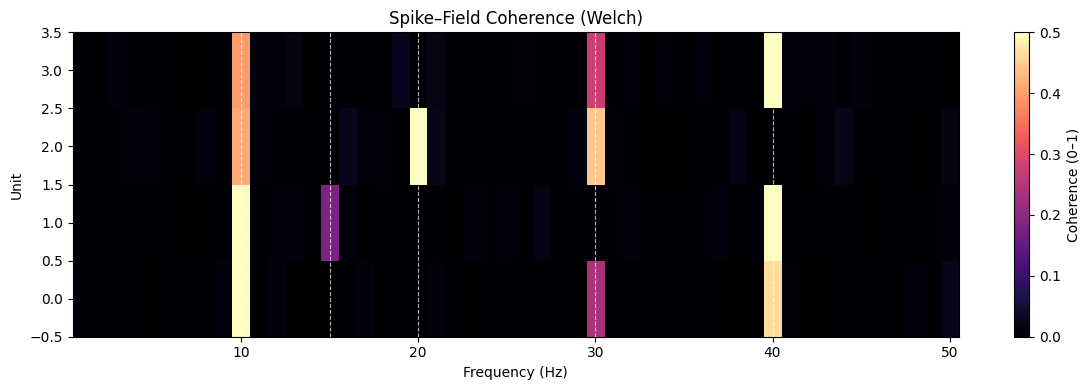

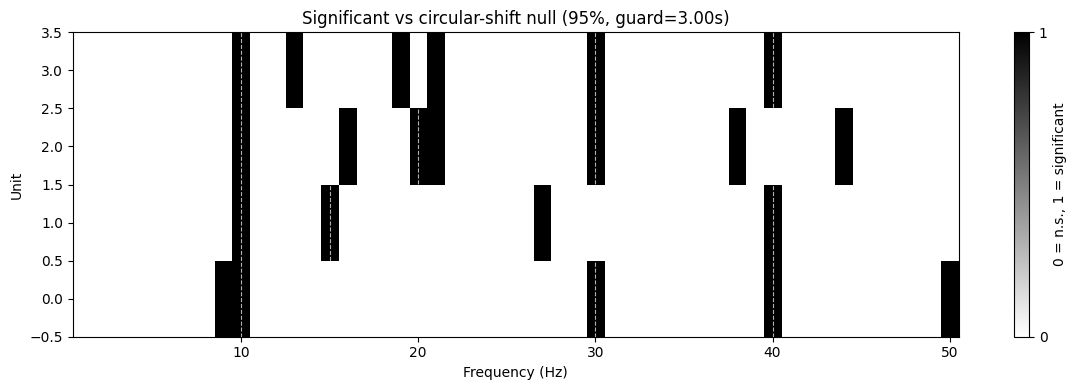

In [ ]:
# ================= PLOTS (all in their OWN units; NO interpolation across units) =================

coh_surr_sig = np.zeros_like(coh_obs)
for u in range(n_units):
    y0 = zscore(spikes_units[u].astype(float))
    surr_vals = np.zeros((n_shuff, len(freqs_eval)), float)
    for s in range(n_shuff):
        shift = rng_coh.integers(guard_samp, T - guard_samp)  # uniform in [G, T-G]
        y_s   = np.roll(y0, shift)
        surr_vals[s] = coherence_at_freqs(x_base, y_s, fs_spk, freqs_eval)
    coh_surr_sig[u] = np.percentile(surr_vals, 99, axis=0)
sig_mask = (coh_obs > coh_surr_sig)   

extent = [freqs_eval[0]-0.5, freqs_eval[-1]+0.5, -0.5, n_units-0.5]
# (1) SFC value heatmap (unitless; 0..1)
fig_sfc, ax_sfc = plt.subplots(figsize=(12, 4))
im_sfc = ax_sfc.imshow(
    coh_obs, aspect='auto', origin='lower', extent=extent,
    vmin=0.0, vmax=0.5, cmap='magma'
)
ax_sfc.set_xlabel('Frequency (Hz)')
ax_sfc.set_ylabel('Unit')
ax_sfc.set_title('Spike–Field Coherence (Welch)')
for f in freqs_hz:
    ax_sfc.axvline(f, color='w', linestyle='--', linewidth=0.8, alpha=0.7)
plt.colorbar(im_sfc, ax=ax_sfc, label='Coherence (0–1)')
plt.tight_layout()
plt.show()

# (2) Significance heatmap (binary 0/1)
fig_sig, ax_sig = plt.subplots(figsize=(12, 4))
im_sig = ax_sig.imshow(
    sig_mask.astype(int), aspect='auto', origin='lower', extent=extent,
    vmin=0, vmax=1, cmap='gray_r', interpolation='nearest'
)
ax_sig.set_xlabel('Frequency (Hz)')
ax_sig.set_ylabel('Unit')
ax_sig.set_title(f'Significant vs circular-shift null (95%, guard={guard_sec:.2f}s)')
for f in freqs_hz:
    ax_sig.axvline(f, color='w', linestyle='--', linewidth=0.8, alpha=0.7)
plt.colorbar(im_sig, ax=ax_sig, ticks=[0,1], label='0 = n.s., 1 = significant')
plt.tight_layout()
plt.show()

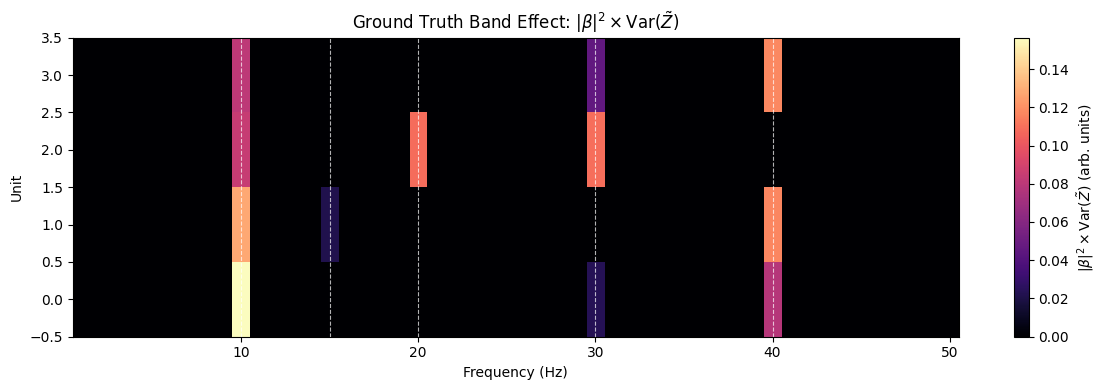

In [154]:
# ======= Ground-truth band effect (variance contribution) =======
# EV_{u,b} ∝ |β_{u,b}|^2 * S_b, with S_b from Z̃_b(t_fine) = e^{iω_b t} · interp(Z_true_b, t→t_fine)

from scipy.interpolate import interp1d

# 1) Band variances from the predictor actually used by spikes (Z̃ on t_fine)
S_b = np.zeros(len(freqs_hz), float)
for b, f in enumerate(freqs_hz):
    ω = 2*np.pi*float(f)
    Zb_fine = interp1d(time, Z_true[b], kind="linear", fill_value="extrapolate")(t_fine)  # complex
    Z_til   = np.exp(1j*ω*t_fine) * Zb_fine
    zr = np.asarray(Z_til.real, float)
    zi = np.asarray(Z_til.imag, float)
    S_b[b] = 0.5 * (zr.var() + zi.var())

# 2) Per-unit, per-band effect: EV (unnormalized) and A (within-unit normalized)
EV_true = np.zeros((n_units, len(freqs_hz)), float)
A_true  = np.zeros_like(EV_true)

for u in range(n_units):
    beta_u = np.asarray(beta_units[u], float)  # [β0, βR_0, βI_0, βR_1, βI_1, ...]
    ev_u = np.zeros(len(freqs_hz), float)
    for b in range(len(freqs_hz)):
        betaR = beta_u[1 + 2*b]
        betaI = beta_u[1 + 2*b + 1]
        ev_u[b] = (betaR*betaR + betaI*betaI) * S_b[b]  # |β|^2 * S_b
    EV_true[u] = ev_u
    denom = ev_u.sum()
    if denom > 0:
        A_true[u] = ev_u / denom  # fractional attribution per unit

# 3) Map to your integer frequency evaluation grid for heatmap (like mag_true)
effect_EV = np.zeros((n_units, len(freqs_eval)), float)
effect_A  = np.zeros_like(effect_EV)
for b, f in enumerate(freqs_hz):
    f_idx = int(np.argmin(np.abs(freqs_eval - f)))
    effect_EV[:, f_idx] = EV_true[:, b]
    effect_A[:,  f_idx] = A_true[:,  b]

# ----- Plot (drop-in replacement for the old mag_true heatmap) -----
gt_vmax = float(np.nanmax(effect_EV)) if np.any(effect_EV > 0) else 1.0
fig_gt, ax_gt = plt.subplots(figsize=(12, 4))
im_gt = ax_gt.imshow(
    effect_EV, aspect='auto', origin='lower', extent=extent,
    vmin=0.0, vmax=gt_vmax, cmap='magma', interpolation='nearest'
)
ax_gt.set_xlabel('Frequency (Hz)')
ax_gt.set_ylabel('Unit')
ax_gt.set_title(r'Ground Truth Band Effect: $|\beta|^2 \times \mathrm{Var}(\tilde Z)$')

for f in freqs_hz:
    ax_gt.axvline(f, color='w', linestyle='--', linewidth=0.8, alpha=0.7)
plt.colorbar(im_gt, ax=ax_gt, label=r'$|\beta|^2 \times \mathrm{Var}(\tilde Z)$ (arb. units)')

plt.tight_layout()
plt.show()



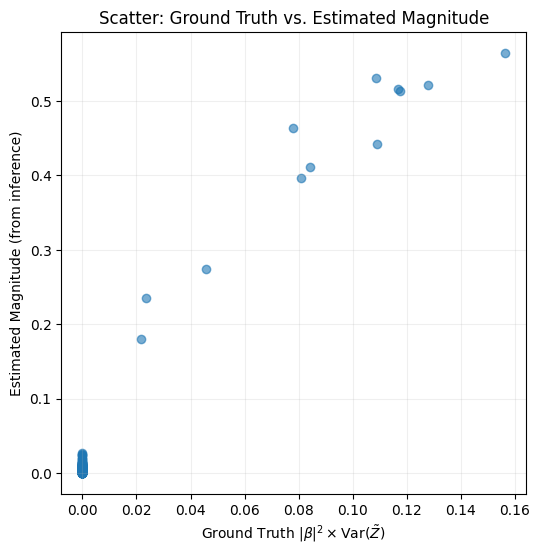

In [155]:
# Compare as scatter plot 
# Flatten the two heatmaps and plot scatter plot
x = effect_EV.flatten()
y = coh_obs.flatten()
plt.figure(figsize=(6,6))
plt.scatter(x, y, alpha=0.6)
plt.xlabel(r'Ground Truth $|\beta|^2 \times \mathrm{Var}(\tilde Z)$')
plt.ylabel('Estimated Magnitude (from inference)')
plt.title('Scatter: Ground Truth vs. Estimated Magnitude')
plt.grid(True, alpha=0.2)
plt.show()

In [156]:
# === Run joint inference on THIS simulated dataset (no changes to simulator) ===
import time, numpy.random as npr
from src.warmstart import em_warmstart
from src.beta_sampler import build_design, gibbs_update_beta_robust as _gibbs_update_beta_robust
from src.utils_spikes import build_history_lags_binary_multi
from src.utils_joint import extract_band_reim_with_var
from src.joint_inference_core import joint_kf_rts_moments

import importlib
import src.run_joint_inference
importlib.reload(src.run_joint_inference)
from src.run_joint_inference import run_joint_inference, InferenceConfig

from src.utils_spikes import build_history_lags_binary_multi, downsample_binary_or, check_spike_shape
downsample_factor = 1
spikes_S = downsample_binary_or(spikes_units.astype(np.float32)  , downsample_factor )  # (S, T_f)
# Use your spike grid from the sim directly
H_hist_S = build_history_lags_binary_multi(spikes_S, n_lags=20)
window_sec = 2.0
# Warm start from your already-computed spectrogram tfr_ds (F, K, T_ds)
params0, xs0, Ps0 = em_warmstart(
    tfr_ds, db=window_sec,
    em_kwargs=dict(max_iter=3000, tol=1e-4, sig_eps_init=1,
                   verbose=False, freeze_lam_iters=0, obs_cut=None)
)
theta0 = params0
gibbs_update_beta_robust = _gibbs_update_beta_robust

# Inference config (same style as your prod script; tweak if you like)
cfg = InferenceConfig(
    fixed_iter=200,
    n_refreshes=5,
    inner_steps_per_refresh=100,
    omega_floor=1e-4,
    sigma_u=1e-5
)

# RNG setup
ss        = npr.SeedSequence()
seed_u32  = ss.generate_state(1, dtype=np.uint32)[0].item()
rng_np    = npr.RandomState(seed_u32)

import jax, jax.random as jr, jax.numpy as jnp
key_jax = jr.PRNGKey(seed_u32)

t0 = time.time()
beta_hat, gamma_hat, theta_hat, trace = run_joint_inference(
    Y_cube_block=tfr_ds,                     # (F, K, T_ds) from your sim
    params0=theta0,
    spikes=spikes_S,                         # (S, T_fine) from your sim
    H_hist=H_hist_S,                         # (S, T_fine, R)
    all_freqs=freqs,                         # same 'freqs' you used for TFR
    build_design=build_design,
    extract_band_reim_with_var=extract_band_reim_with_var,
    gibbs_update_beta_robust=gibbs_update_beta_robust,
    joint_kf_rts_moments=joint_kf_rts_moments,
    em_theta_from_joint=None,
    config=cfg,
    delta_spk=float(dt_spk) * downsample_factor,                 # from your sim (e.g., 0.005)
    window_sec=float(window_sec),            # same as used for TFR (e.g., 2.0)
    rng_pg=rng_np, key_jax=key_jax,
    offset_sec=0.0
)
try:
    if isinstance(beta_hat, jnp.ndarray): beta_hat.block_until_ready()
except Exception:
    pass
print(f"[SIM] run_joint_inference wall time: {time.time()-t0:.3f}s")

# --- Save everything (posterior + trace + a couple of handy metadata) ---
def _extract_trace_beta(trace):
    if trace is None: return None
    if isinstance(trace, dict):
        if "beta" in trace:       # (T_draws, S, P)
            tb = trace["beta"]
            return tb if isinstance(tb, np.ndarray) else np.asarray(list(tb))
        if "beta_last" in trace:  # (S, P)
            return np.asarray(trace["beta_last"])[None, ...]
        return None
    if hasattr(trace, "beta"):
        tb = getattr(trace, "beta")
        return tb if isinstance(tb, np.ndarray) else np.asarray(list(tb))
    return None


Unfreeze lam at 0
lat_reim_jax device: cuda:0


Warm-up (β/γ per train):   0%|          | 0/200 [00:00<?, ?it/s]/orcd/data/ekmiller/001/bowen/spike-field-joint-inference/src/beta_sampler.py:174: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  key, subk = jr.split(key); eps = jr.normal(subk, (p,), dtype=jnp.float64)
Latent refresh passes: 100%|██████████| 5/5 [02:45<00:00, 33.06s/pass]

[SIM] run_joint_inference wall time: 255.584s


In [157]:
out_sim_path = "joint_on_sim.npz"
# save all trace 
trace_path = "trace.npz"
# Save the trace to a separate file for later inspection
if trace is not None:
    # Attempt to save as a numpy archive, fallback to pickle if needed
    try:
        # If trace is a dict of arrays, save each as .npz
        if isinstance(trace, dict):
            np.savez_compressed(trace_path, **trace)
        else:
            # Save generic object with pickle
            import pickle
            with open(trace_path.replace('.npz', '.pkl'), 'wb') as f:
                pickle.dump(trace, f)
        print(f"[SIM] Saved trace → {trace_path}")
    except Exception as e:
        print(f"[SIM] Could not save trace: {e}")
save_kwargs = dict(
    
    beta_hat=beta_hat, gamma_hat=gamma_hat, theta_hat=theta_hat,
    freqs=freqs, window_sec=float(window_sec),
    dt_spk=float(dt_spk), rng_seed=int(seed_u32),
)
trace_beta = _extract_trace_beta(trace)
if trace_beta is not None:
    save_kwargs["trace_beta"] = trace_beta

np.savez_compressed(out_sim_path, **save_kwargs)
print(f"[SIM] Saved posterior → {out_sim_path} "
      f"{'(with trace_beta)' if 'trace_beta' in save_kwargs else '(beta_hat only)'}")


[SIM] Saved trace → trace.npz
[SIM] Saved posterior → joint_on_sim.npz (with trace_beta)


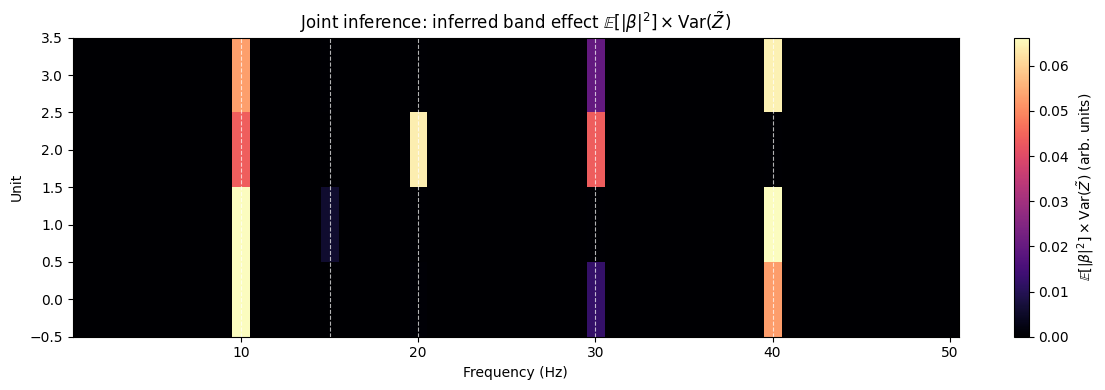

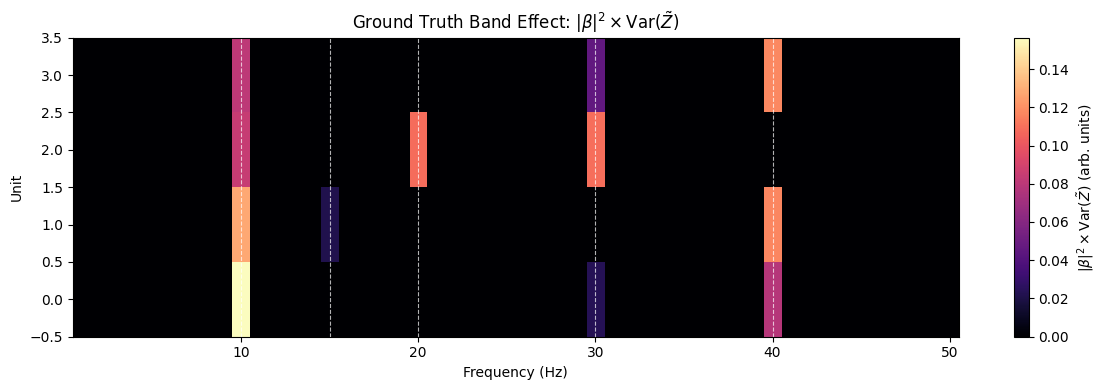

In [158]:
# ===== Inferred band effect from joint inference (uses trace.beta, no postB needed) =====
# Effect per unit × band:  E[|β|^2] * Var_t([Re Z̃_b, Im Z̃_b])

import numpy as np
import matplotlib.pyplot as plt

# --- 0) latent regressors on the spike grid: columns [Re1, Im1, Re2, Im2, ...]
lat_feat = np.asarray(trace.latent[-1])                    # (T, 2B)
assert lat_feat.ndim == 2 and lat_feat.shape[1] % 2 == 0, f"latent features must be (T, 2B); got {lat_feat.shape}"
B = lat_feat.shape[1] // 2

# --- 1) predictor variance per band (time variance)
S_b_hat = np.empty(B, dtype=float)
for b in range(B):
    mR = lat_feat[:, 2*b]
    mI = lat_feat[:, 2*b+1]
    S_b_hat[b] = 0.5 * (np.var(mR, ddof=0) + np.var(mI, ddof=0))

# --- 2) Build β chain from trace.beta (fallback to beta_hat if needed)
def _stack_trace_beta(beta_seq):
    buf = []
    S_units = None
    P = None
    for b in beta_seq:
        A = np.asarray(b)
        if A.ndim == 1:
            A = A[None, :]                # (1, P)
        if A.ndim != 2:
            continue
        if S_units is None:
            S_units, P = A.shape
        if A.shape != (S_units, P):
            continue
        buf.append(A.astype(np.float64, copy=False))
    if not buf:
        return None
    return np.stack(buf, axis=0)          # (Tdraws, S, P)

beta_chain = _stack_trace_beta(getattr(trace, 'beta', []))  # may be None

if beta_chain is not None:
    # Expect layout [β0, βR1, βI1, βR2, βI2, ...]
    S_units = beta_chain.shape[1]
    beta_R_draws = beta_chain[:, :, 1::2][:, :, :B]         # (Tdraws, S, B)
    beta_I_draws = beta_chain[:, :, 2::2][:, :, :B]         # (Tdraws, S, B)
    E_beta2 = (beta_R_draws**2 + beta_I_draws**2).mean(axis=0)  # (S, B)
else:
    BETA = np.asarray(beta_hat)                              # (S, 1+2B) or (1+2B,)
    if BETA.ndim == 1:
        BETA = BETA[None, :]
    S_units = BETA.shape[0]
    beta_R = BETA[:, 1::2][:, :B]
    beta_I = BETA[:, 2::2][:, :B]
    E_beta2 = (beta_R**2 + beta_I**2)                        # (S, B)

# --- 3) Effect per unit × band
effect_SB = E_beta2 * S_b_hat[None, :]                       # (S, B)

# --- 4) Map to integer eval grid (self-contained helper)
try:
    band_freqs = np.asarray(freqs, float)[:B]
except NameError:
    try:
        band_freqs = np.asarray(freqs, float)[:B]
    except NameError:
        raise RuntimeError("Need 'freqs' (or 'all_freqs') to map bands to freqs_eval.")

eval_freqs = np.asarray(freqs_eval, float)
def _place_on_eval_grid_local(X_SB, band_freqs, eval_freqs):
    S_loc, B_loc = X_SB.shape
    out = np.zeros((S_loc, eval_freqs.size), dtype=X_SB.dtype)
    for b_idx, f in enumerate(band_freqs):
        j = int(np.argmin(np.abs(eval_freqs - f)))
        out[:, j] = X_SB[:, b_idx]
    return out

effect_eval = _place_on_eval_grid_local(effect_SB, band_freqs, eval_freqs)

# --- 5) Plot heatmap (standalone extent)
extent_ev = [float(eval_freqs[0]) - 0.5,
             float(eval_freqs[-1]) + 0.5,
             -0.5, float(S_units) - 0.5]

fig_ev, ax_ev = plt.subplots(figsize=(12, 4))
vmax_ev = float(np.percentile(effect_eval[effect_eval > 0], 99)) if np.any(effect_eval > 0) else 1.0
im_ev = ax_ev.imshow(effect_eval, aspect='auto', origin='lower', extent=extent_ev,
                     vmin=0.0, vmax=vmax_ev, cmap='magma', interpolation='nearest')
ax_ev.set_xlabel('Frequency (Hz)')
ax_ev.set_ylabel('Unit')
ax_ev.set_title(r'Joint inference: inferred band effect $\mathbb{E}[|\beta|^2]\times \mathrm{Var}(\tilde Z)$')
try:
    for f in np.asarray(freqs_hz, float):
        ax_ev.axvline(float(f), color='w', linestyle='--', linewidth=0.8, alpha=0.7)
except NameError:
    pass
plt.colorbar(im_ev, ax=ax_ev, label=r'$\mathbb{E}[|\beta|^2]\times \mathrm{Var}(\tilde Z)$ (arb. units)')
plt.tight_layout()
plt.show()


# --- Ground truth panel (use the SAME eval grid + its own extent) ---
eval_freqs = np.asarray(freqs_eval, float)
extent_gt = [float(eval_freqs[0]) - 0.5,
             float(eval_freqs[-1]) + 0.5,
             -0.5, float(effect_EV.shape[0]) - 0.5]  # rows = n_units

gt_vmax = float(np.nanmax(effect_EV)) if np.any(effect_EV > 0) else 1.0
fig_gt, ax_gt = plt.subplots(figsize=(12, 4))
im_gt = ax_gt.imshow(
    effect_EV, aspect='auto', origin='lower', extent=extent_gt,
    vmin=0.0, vmax=gt_vmax, cmap='magma', interpolation='nearest'
)
ax_gt.set_xlabel('Frequency (Hz)')
ax_gt.set_ylabel('Unit')
ax_gt.set_title(r'Ground Truth Band Effect: $|\beta|^2 \times \mathrm{Var}(\tilde Z)$')

for f in np.asarray(freqs_hz, float):
    ax_gt.axvline(float(f), color='w', linestyle='--', linewidth=0.8, alpha=0.7)

plt.colorbar(im_gt, ax=ax_gt, label=r'$|\beta|^2 \times \mathrm{Var}(\tilde Z)$ (arb. units)')
plt.tight_layout()
plt.show()



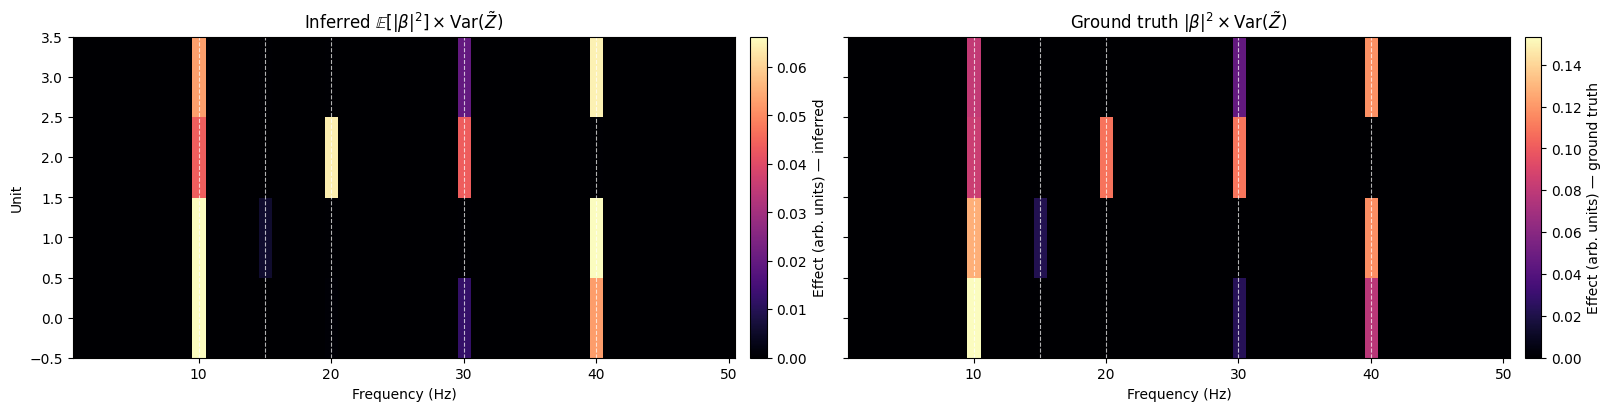

In [159]:
# === Side-by-side, identical-size heatmaps (inferred vs ground truth) ===
import numpy as np
import matplotlib.pyplot as plt

eval_freqs = np.asarray(freqs_eval, float)

# Common extent (same x/y limits for both plots)
n_units = effect_eval.shape[0]  # should match effect_EV.shape[0]
extent_common = [float(eval_freqs[0]) - 0.5,
                 float(eval_freqs[-1]) + 0.5,
                 -0.5, float(n_units) - 0.5]

# Independent color scales (each panel gets its own)
vmax_inf = float(np.percentile(effect_eval[effect_eval > 0], 99)) if np.any(effect_eval > 0) else 1.0
vmax_gt  = float(np.percentile(effect_EV[effect_EV > 0], 99))     if np.any(effect_EV > 0) else 1.0
vmin_inf = 0.0
vmin_gt  = 0.0

fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=True, sharey=True, constrained_layout=True)

# (Left) Inferred effect
im0 = axes[0].imshow(
    effect_eval, aspect='auto', origin='lower', extent=extent_common,
    vmin=vmin_inf, vmax=vmax_inf, cmap='magma', interpolation='nearest'
)
axes[0].set_title(r'Inferred $\mathbb{E}[|\beta|^2]\times\mathrm{Var}(\tilde Z)$')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Unit')
cb0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.02)
cb0.set_label(r'Effect (arb. units) — inferred')

# (Right) Ground truth effect
im1 = axes[1].imshow(
    effect_EV, aspect='auto', origin='lower', extent=extent_common,
    vmin=vmin_gt, vmax=vmax_gt, cmap='magma', interpolation='nearest'
)
axes[1].set_title(r'Ground truth $|\beta|^2\times\mathrm{Var}(\tilde Z)$')
axes[1].set_xlabel('Frequency (Hz)')
cb1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.02)
cb1.set_label(r'Effect (arb. units) — ground truth')

# Vertical guides (optional)
for ax in axes:
    for f in np.asarray(freqs_hz, float):
        ax.axvline(float(f), color='w', linestyle='--', linewidth=0.8, alpha=0.7)

plt.show()


Text(0.5, 1.0, 'Scatter: Ground Truth vs. Estimated Effect')

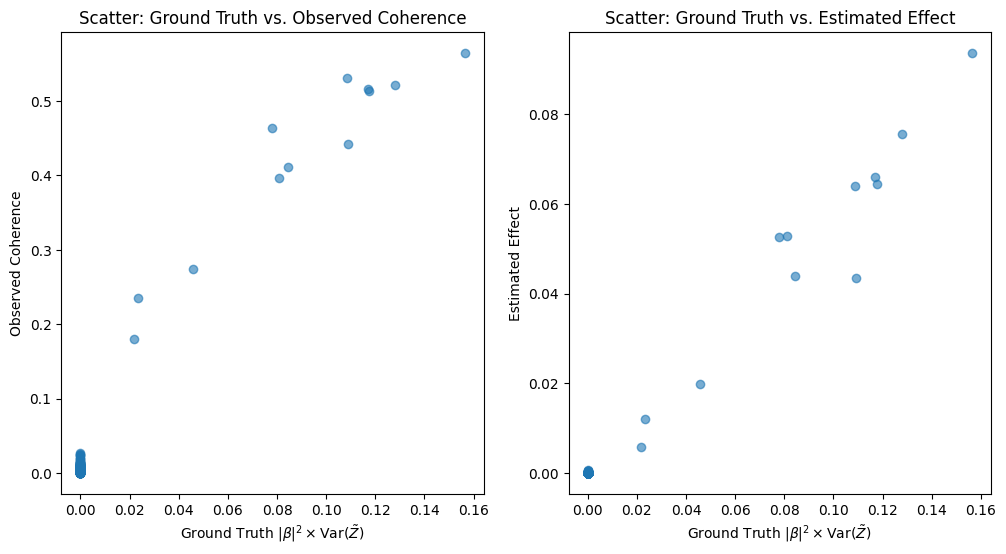

In [160]:
# Compare as scatter plot 
# Flatten the two heatmaps and plot scatter plot
x = effect_EV.flatten()
y1 = coh_obs.flatten()
y2 = effect_SB.flatten()    
figs, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(x, y1, alpha=0.6)
axs[0].set_xlabel(r'Ground Truth $|\beta|^2 \times \mathrm{Var}(\tilde Z)$')
axs[0].set_ylabel('Observed Coherence')
axs[0].set_title('Scatter: Ground Truth vs. Observed Coherence')
axs[1].scatter(x, y2, alpha=0.6)
axs[1].set_xlabel(r'Ground Truth $|\beta|^2 \times \mathrm{Var}(\tilde Z)$')
axs[1].set_ylabel('Estimated Effect')
axs[1].set_title('Scatter: Ground Truth vs. Estimated Effect')


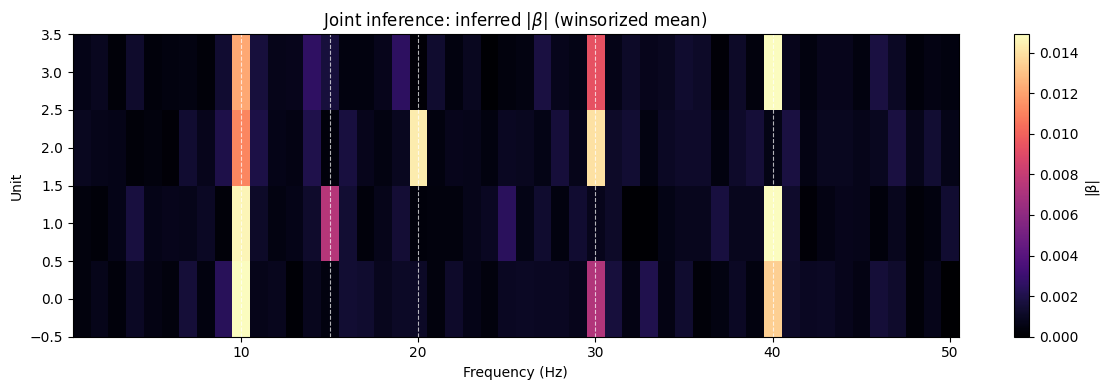

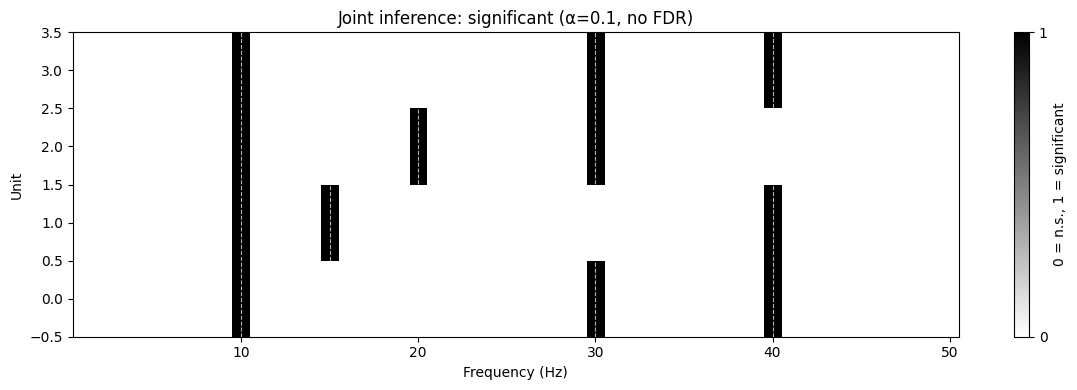

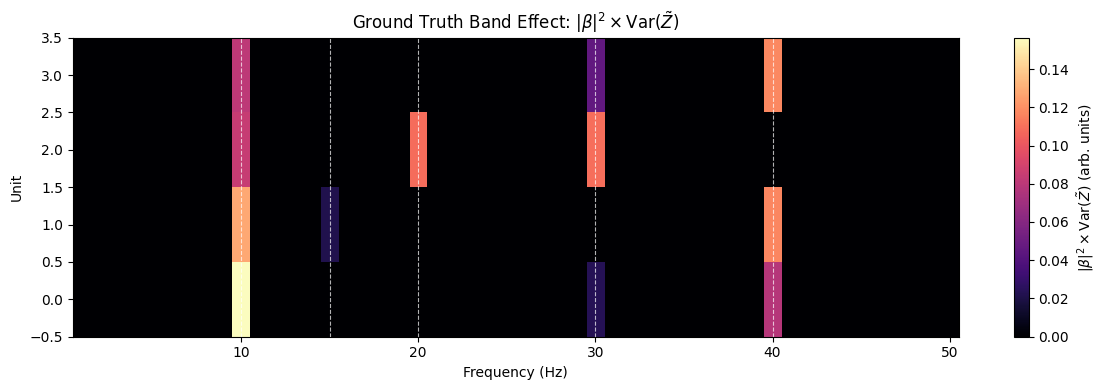

In [161]:
# ================= Joint inference heatmaps (winsorized Wald, NO FDR) — COMPLETE =================
# Expects: beta_hat, freqs, freqs_eval, freqs_hz, and optionally trace_beta; optional mag_true.

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from types import SimpleNamespace

# ---------- helpers ----------
def winsorize_cols(X, lo_q, hi_q):
    lo = np.percentile(X, 100*lo_q, axis=0)
    hi = np.percentile(X, 100*hi_q, axis=0)
    return np.clip(X, lo, hi)

def _stack_trace_beta(beta_list):
    buf = []
    S = P = None
    for b in beta_list:
        if b is None:
            continue
        b = np.asarray(b)
        if b.ndim == 1:
            b = b[None, :]
        if b.ndim != 2:
            continue
        if S is None:
            S, P = b.shape
        if b.shape != (S, P):
            continue
        buf.append(b.astype(np.float64, copy=False))
    if not buf:
        raise ValueError("trace.beta contains no usable (S,P) arrays")
    return np.stack(buf, axis=0)  # (Tdraws, S, P)

def summarize_beta_trace_minimal(trace_like, all_freqs, fix_iter=0, thin_beta=1, burnin_frac=0.0):
    BETA = _stack_trace_beta(list(trace_like.beta))          # (Tdraws, S, 1+2B)
    n_draws, S, P = BETA.shape
    assert (P - 1) % 2 == 0, "β layout must be [β0, (βR, βI) per band]"
    B = (P - 1) // 2
    joint_draws = n_draws - fix_iter
    burnin = int(burnin_frac * joint_draws) + int(fix_iter)
    postB = BETA[burnin::thin_beta]
    mask  = np.isfinite(postB).all(axis=(1,2))
    postB = postB[mask]
    band_freqs = np.asarray(all_freqs)[:B]
    return {"postB": postB, "band_freqs": band_freqs}

def _place_on_eval_grid(X_SB, band_freqs, eval_freqs):
    S, B = X_SB.shape
    out = np.zeros((S, len(eval_freqs)), dtype=X_SB.dtype)
    for b, f in enumerate(band_freqs):
        idx = int(np.argmin(np.abs(eval_freqs - f)))
        out[:, idx] = X_SB[:, b]
    return out

# ---------- bootstrap posterior chain ----------
if 'trace_beta' in globals() and trace_beta is not None and np.size(trace_beta) > 0:
    chain = np.asarray(trace_beta)                     # (Tdraw, S, P)
else:
    chain = np.repeat(np.asarray(beta_hat)[None, ...], 64, axis=0)  # fallback pseudo-chain

trace_like = SimpleNamespace(beta=[chain[i] for i in range(chain.shape[0])])

# ---------- summarize to postB ----------
result = summarize_beta_trace_minimal(trace_like, all_freqs=freqs, fix_iter=0, thin_beta=1, burnin_frac=0.0)
postB       = result["postB"]                      # (N_draws, S, 1+2B)
band_freqs  = np.asarray(result["band_freqs"], float)
S           = postB.shape[1]
B           = (postB.shape[2] - 1) // 2

# ---------- config (no FDR) ----------
trim      = 0.01
ridge     = 1e-9
alpha_p   = 0.1         # per-band p-threshold (2 dof)

# ---------- winsorized Wald per unit/band, no multiple-comparison correction ----------
pvals_all     = np.ones((S, B), dtype=float)
sig_all       = np.zeros((S, B), dtype=int)
mag_mean_all  = np.zeros((S, B), dtype=float)

for s in range(S):
    beta_R = postB[:, s, 1::2][:, :B]
    beta_I = postB[:, s, 2::2][:, :B]
    pvals  = np.ones(B, float)
    mags   = np.zeros(B, float)

    for b in range(B):
        Xb = np.column_stack([beta_R[:, b], beta_I[:, b]])
        Xw = winsorize_cols(Xb, trim, 1 - trim) if trim > 0 else Xb
        mu_b  = Xw.mean(axis=0)
        Sig_b = np.cov(Xw, rowvar=False, bias=True) + ridge*np.eye(2)
        W_b   = float(mu_b @ np.linalg.solve(Sig_b, mu_b))
        pvals[b] = 1.0 - chi2.cdf(W_b, df=2)
        mags[b]  = np.linalg.norm(mu_b)

    pvals_all[s]    = pvals
    sig_all[s]      = (pvals < alpha_p).astype(int)   # <-- NO FDR
    mag_mean_all[s] = mags

# ---------- map to eval grid ----------
mag_eval = _place_on_eval_grid(mag_mean_all, band_freqs, freqs_eval)
sig_eval = _place_on_eval_grid(sig_all,      band_freqs, freqs_eval)

# ---------- plots ----------
n_units = S
extent = [freqs_eval[0]-0.5, freqs_eval[-1]+0.5, -0.5, n_units-0.5]

# (1) |β| heatmap
fig_b, ax_b = plt.subplots(figsize=(12, 4))
vmax_b = float(np.percentile(mag_eval[mag_eval>0], 99)) if np.any(mag_eval>0) else 1.0
im_b = ax_b.imshow(mag_eval, aspect='auto', origin='lower', extent=extent,
                   vmin=0.0, vmax=vmax_b, cmap='magma', interpolation='nearest')
ax_b.set_xlabel('Frequency (Hz)'); ax_b.set_ylabel('Unit')
ax_b.set_title('Joint inference: inferred $|\\beta|$ (winsorized mean)')
for f in freqs_hz: ax_b.axvline(f, color='w', linestyle='--', linewidth=0.8, alpha=0.7)
plt.colorbar(im_b, ax=ax_b, label='|β|'); plt.tight_layout(); plt.show()

# (2) Significance heatmap (NO FDR)
fig_s, ax_s = plt.subplots(figsize=(12, 4))
im_s = ax_s.imshow(sig_eval, aspect='auto', origin='lower', extent=extent,
                   vmin=0, vmax=1, cmap='gray_r', interpolation='nearest')
ax_s.set_xlabel('Frequency (Hz)'); ax_s.set_ylabel('Unit')
ax_s.set_title(f'Joint inference: significant (α={alpha_p}, no FDR)')
for f in freqs_hz: ax_s.axvline(f, color='w', linestyle='--', linewidth=0.8, alpha=0.7)
plt.colorbar(im_s, ax=ax_s, ticks=[0,1], label='0 = n.s., 1 = significant')
plt.tight_layout(); plt.show()

# (3) Ground truth panel (optional)

# ----- Plot (drop-in replacement for the old mag_true heatmap) -----
gt_vmax = float(np.nanmax(effect_EV)) if np.any(effect_EV > 0) else 1.0
fig_gt, ax_gt = plt.subplots(figsize=(12, 4))
im_gt = ax_gt.imshow(
    effect_EV, aspect='auto', origin='lower', extent=extent,
    vmin=0.0, vmax=gt_vmax, cmap='magma', interpolation='nearest'
)
ax_gt.set_xlabel('Frequency (Hz)')
ax_gt.set_ylabel('Unit')
ax_gt.set_title(r'Ground Truth Band Effect: $|\beta|^2 \times \mathrm{Var}(\tilde Z)$')

for f in freqs_hz:
    ax_gt.axvline(f, color='w', linestyle='--', linewidth=0.8, alpha=0.7)
plt.colorbar(im_gt, ax=ax_gt, label=r'$|\beta|^2 \times \mathrm{Var}(\tilde Z)$ (arb. units)')

plt.tight_layout()
plt.show()




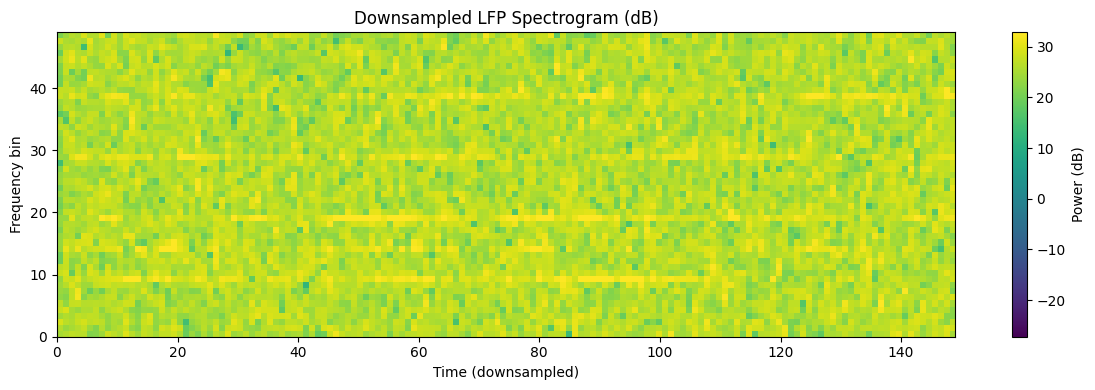

In [165]:
spec0 = (np.abs(tfr_ds)**2).mean(axis=1).astype(np.float32)        # (F, T_ds)
spec0_db = (10.0*np.log10(spec0 + 1e-20)).astype(np.float32)       # (F, T_ds)

# plot spec0_db
fig_spec, ax_spec = plt.subplots(figsize=(12, 4))
vmax_spec = np.percentile(spec0_db, 99) if np.any(np.isfinite(spec0_db)) else 0.0
im_spec = ax_spec.imshow(spec0_db, aspect='auto', origin='lower',
                        extent=[0, spec0_db.shape[1]-1, 0, spec0_db.shape[0]-1],
                        vmin=vmax_spec - 60, vmax=vmax_spec, cmap='viridis', interpolation='nearest')
ax_spec.set_xlabel('Time (downsampled)')
ax_spec.set_ylabel('Frequency bin')
ax_spec.set_title('Downsampled LFP Spectrogram (dB)')
plt.colorbar(im_spec, ax=ax_spec, label='Power (dB)')
plt.tight_layout()
plt.show()



/tmp/ipykernel_2981300/3650075005.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


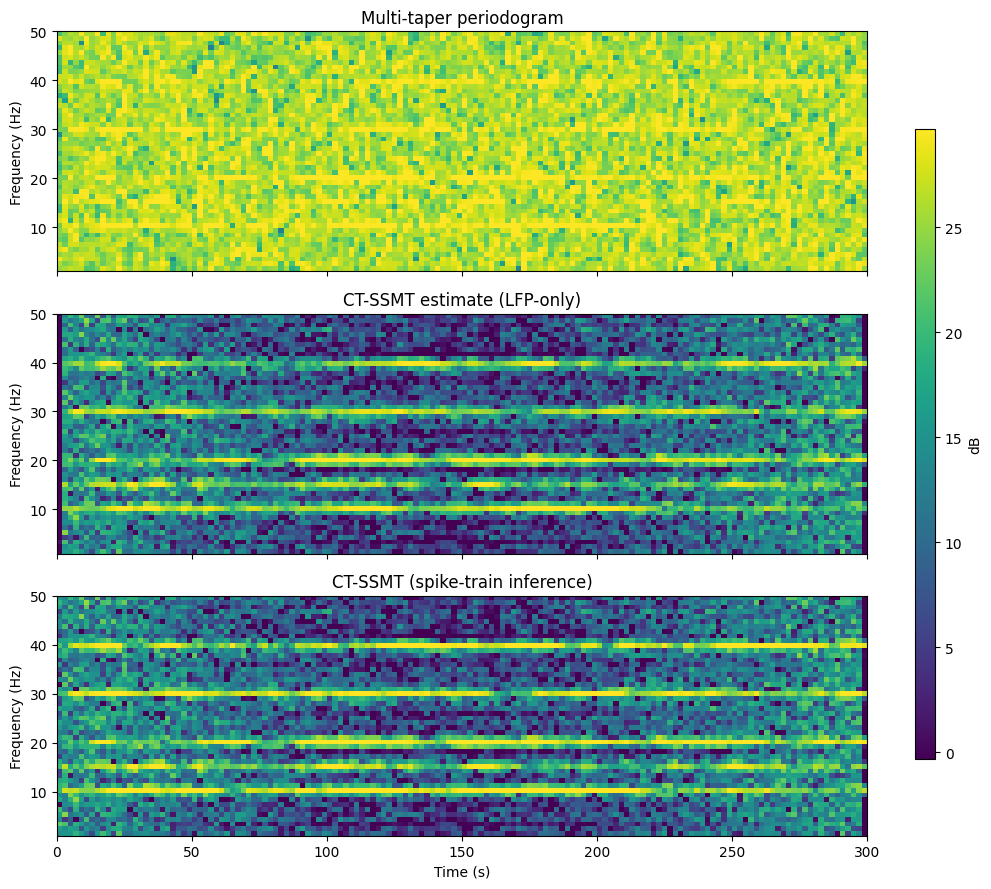

In [170]:
# ================= Reconstruct spectrogram from fine latents & compare =================
import numpy as np
import matplotlib.pyplot as plt

EPS = 1e-20
J, M = tfr_ds.shape[0], tfr_ds.shape[1]
all_freqs = freqs
# --- helper: fine (T_f, 2*J*M) -> complex cube (J, M, T_f)
def fine_to_cube_complex(fine_latent: np.ndarray, J: int, M: int) -> np.ndarray:
    """
    fine_latent: (T_f, d) with d == 2*J*M, flattened as (J, M, 2) in C-order
    returns:     (J, M, T_f) complex
    """
    T_f, d = fine_latent.shape
    assert d == 2 * J * M, f"expected d=2*J*M={2*J*M}, got {d}"
    tmp = fine_latent.reshape(T_f, J, M, 2, order="C")
    Z = (tmp[..., 0] + 1j * tmp[..., 1]).transpose(1, 2, 0)  # (J, M, T_f)
    return Z

# --- (A) Multi-taper periodogram from observed TFR (derotated & scaled)
# tfr_ds: (J, M, T_ds) complex
P_mt = (np.abs(tfr_ds)**2).mean(axis=1)   # (J, T_ds)
P_mt_db = 10.0 * np.log10(P_mt + EPS)

# --- (B) CT-SSMT estimate from LFP-only smoother (first entry in trace.fine_latent)
fine_lfp_only = np.asarray(trace.fine_latent[0])[:-1]        # align to T_f
Z_lfp = fine_to_cube_complex(fine_lfp_only, J, M)             # (J, M, T_f)
P_ct_lfp = (np.abs(Z_lfp)**2).mean(axis=1)                    # (J, T_f)
# downsample to block grid (by nearest center) for apples-to-apples with P_mt
T_ds = tfr_ds.shape[-1]
window_sec = float(duration_sec / T_ds)
t_block = np.arange(T_ds, dtype=float) * window_sec
t_lat   = np.arange(P_ct_lfp.shape[1], dtype=float) * (window_sec)  # assumes one fine step per block
# If your fine step differs, replace the line above with actual delta_spk
idx_lfp = np.round(np.linspace(0, P_ct_lfp.shape[1]-1, T_ds)).astype(int)
P_ct_lfp_blocks = P_ct_lfp[:, idx_lfp]
P_ct_lfp_db = 10.0 * np.log10(P_ct_lfp_blocks + EPS)

# --- (C) CT-SSMT estimate from spike-train inference (latest in trace.fine_latent)
fine_spk = np.asarray(trace.fine_latent[3:]).mean(axis=0)
Z_spk = fine_to_cube_complex(fine_spk, J, M)                  # (J, M, T_f)
P_ct_spk = (np.abs(Z_spk)**2).mean(axis=1)                    # (J, T_f)
idx_spk = np.round(np.linspace(0, P_ct_spk.shape[1]-1, T_ds)).astype(int)
P_ct_spk_blocks = P_ct_spk[:, idx_spk]
P_ct_spk_db = 10.0 * np.log10(P_ct_spk_blocks + EPS)

# --- Common colour scale (robust or fixed range)
stack_all = np.concatenate([P_mt_db.ravel(), P_ct_lfp_db.ravel(), P_ct_spk_db.ravel()])
vmax = np.nanpercentile(stack_all, 95)
vmin = vmax - 30.0  # 30 dB window like your example

# --- Plot
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True, sharey=True)
titles = ["Multi-taper periodogram",
          "CT-SSMT estimate (LFP-only)",
          "CT-SSMT (spike-train inference)"]

# Time axis extent (seconds) and freq extent
extent = [0.0, float(duration_sec), float(all_freqs[0]), float(all_freqs[-1])]

im0 = axes[0].imshow(P_mt_db, origin='lower', aspect='auto',
                     extent=extent, cmap='viridis', vmin=vmin, vmax=vmax)
axes[0].set_title(titles[0]); axes[0].set_ylabel("Frequency (Hz)")

im1 = axes[1].imshow(P_ct_lfp_db, origin='lower', aspect='auto',
                     extent=extent, cmap='viridis', vmin=vmin, vmax=vmax)
axes[1].set_title(titles[1]); axes[1].set_ylabel("Frequency (Hz)")

im2 = axes[2].imshow(P_ct_spk_db, origin='lower', aspect='auto',
                     extent=extent, cmap='viridis', vmin=vmin, vmax=vmax)
axes[2].set_title(titles[2]); axes[2].set_ylabel("Frequency (Hz)")
axes[2].set_xlabel("Time (s)")

# Single shared colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im0, cax=cax, label="dB")

plt.subplots_adjust(right=0.9, hspace=0.3)
plt.tight_layout(rect=[0, 0, 0.9, 1])


/home/bowen27/miniconda3/envs/jax312/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/bowen27/miniconda3/envs/jax312/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


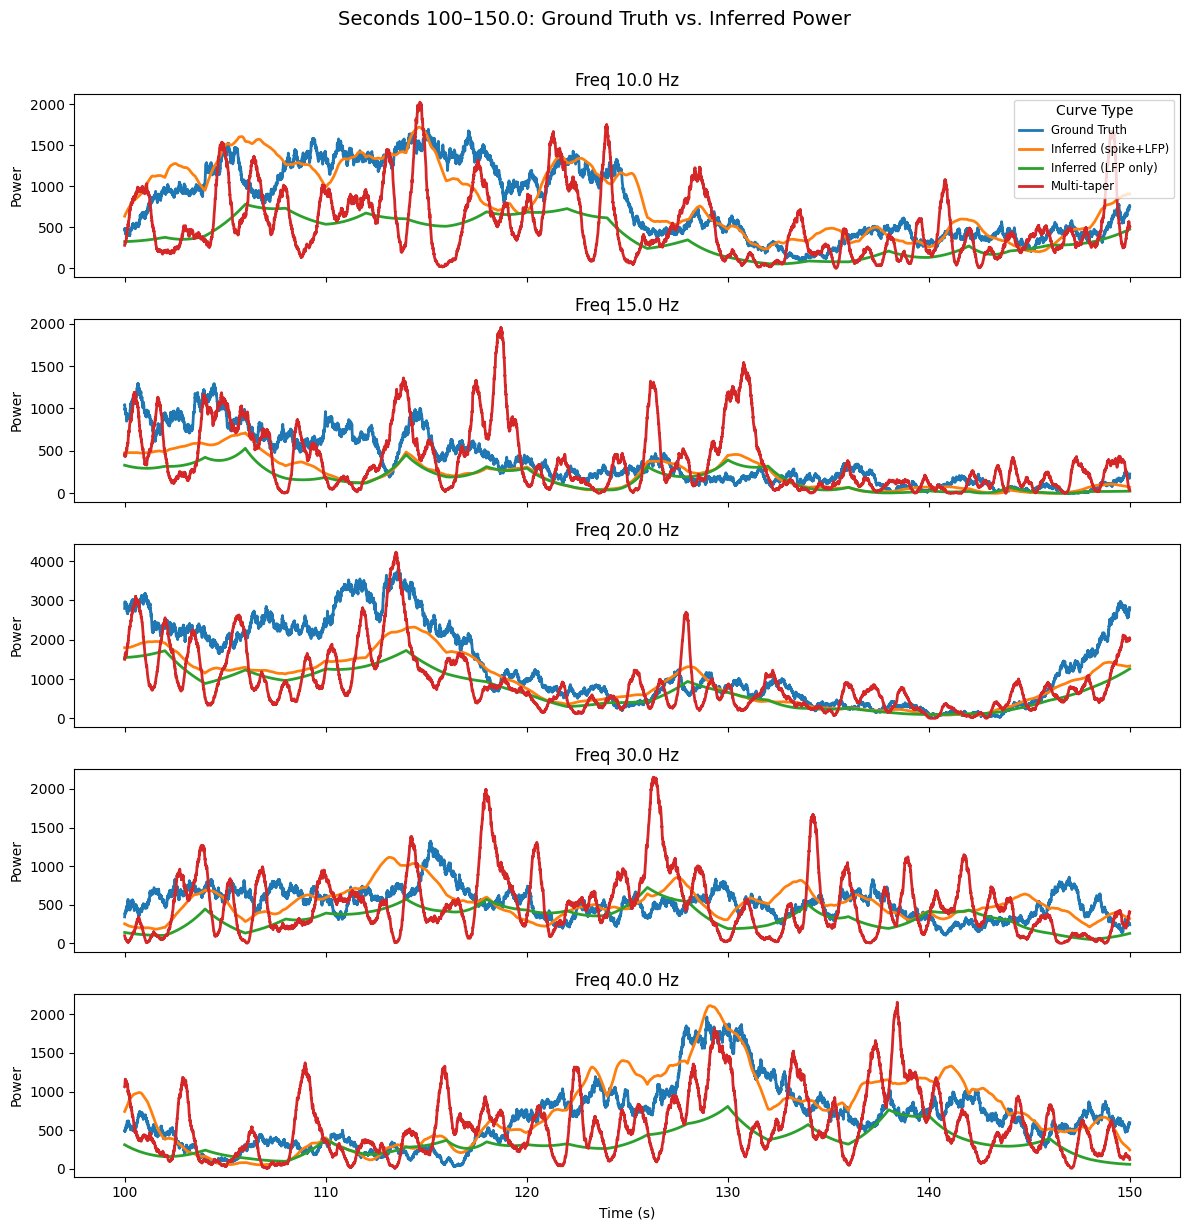

In [173]:
# Compare ground truth power and inference with color marking inference type, each frequency in its own panel
# STOP plotting tfr_ds, use tfr directly and plot the multitaper at the original (non-blocked) time-resolution.

start_sec = 100
plot_sec = 50.0  # seconds

# All reference grid for all estimates
all_freqs = freqs
indexes = [np.argmin(np.abs(all_freqs - fhz)) for fhz in freqs_hz]
find_idx = lambda idx: [idx*6, idx*6+2, idx*6+4]
idx_real = np.array([find_idx(idx) for idx in indexes])
idx_img = np.array([[i + 1 for i in find_idx(idx)] for idx in indexes])

# Ground truth (sample-resolution)
Z_true_time = np.arange(Z_true_all.shape[1]) * (1 / fs)
Z_true_idx_start = int(start_sec * fs)
Z_true_idx_end = Z_true_idx_start + int(plot_sec * fs)

# Inference (block-resolution, delta_spk)
spk_time = np.arange(fine_spk.shape[0]) * delta_spk
Z_spk_averaged = Z_spk.mean(axis=1)
spk_idx_start = int(start_sec / delta_spk)
spk_idx_end = spk_idx_start + int(plot_sec / delta_spk)

lfp_time = np.arange(fine_lfp_only.shape[0]) * delta_spk
Z_lfp_averaged = Z_lfp.mean(axis=1)
lfp_idx_start = spk_idx_start
lfp_idx_end = spk_idx_end

# Multi-taper: USE tfr, not tfr_ds! tfr shape: (freq, tapers, n_samples)
mt_time = Z_true_time  # this is at the original time resolution (sampled at 1/fs)
mt_sample_start = int(start_sec * fs)
tfr_averaged = tfr.mean(axis=1)
mt_sample_end = mt_sample_start + int(plot_sec * fs)
EPS = 1e-12  # Small epsilon to avoid div by zero, etc

# Define inference methods and colors
method_keys = ["gt", "spk","lfp", "mt"]
method_labels = {
    "gt": "Ground Truth",
    "spk": "Inferred (spike+LFP)",
    "lfp": "Inferred (LFP only)",
    "mt": "Multi-taper"
}
method_colors = {
    "gt": "C0",
    "spk": "C1",
    "lfp": "C2",
    "mt": "C3"
}
linestyle = "solid"  # All curves solid, color carries inference type

n_freqs = len(indexes)
fig, axes = plt.subplots(n_freqs, 1, figsize=(12, 2.5*n_freqs), sharex=True)
if n_freqs == 1:
    axes = [axes]

for idx, (ax, fidx) in enumerate(zip(axes, indexes)):
    slices = {
        "gt": (
            Z_true_time[Z_true_idx_start:Z_true_idx_end],
            # multiply by conjugate to get power
            Z_true_all[fidx, Z_true_idx_start:Z_true_idx_end] * np.conj(Z_true_all[fidx, Z_true_idx_start:Z_true_idx_end])
        ),
        "spk": (
            spk_time[spk_idx_start:spk_idx_end],
            Z_spk_averaged[fidx, spk_idx_start:spk_idx_end] * np.conj(Z_spk_averaged[fidx, spk_idx_start:spk_idx_end])
        ),
        "lfp": (
            lfp_time[lfp_idx_start:lfp_idx_end],
            Z_lfp_averaged[fidx, lfp_idx_start:lfp_idx_end] * np.conj(Z_lfp_averaged[fidx, lfp_idx_start:lfp_idx_end])
        ),
        "mt": (
            mt_time[mt_sample_start:mt_sample_end],
            tfr_averaged[fidx, mt_sample_start:mt_sample_end] * np.conj(tfr_averaged[fidx, mt_sample_start:mt_sample_end])
        ),
    }
    for key in method_keys:
        x, y = slices[key]
        n = min(len(x), len(y))
        if n == 0:
            continue
        if n > 0 and np.isfinite(x[:n]).all():
            ax.plot(x[:n], y[:n], color=method_colors[key], lw=2, linestyle=linestyle, alpha=1.0, label=method_labels[key])
    ax.set_ylabel("Power")
    ax.set_title(f"Freq {all_freqs[fidx]:.1f} Hz")

axes[-1].set_xlabel("Time (s)")

# Single legend for method colors
handles = [plt.Line2D([], [], color=method_colors[k], lw=2, label=method_labels[k]) for k in method_keys]
legend_ax = axes[0]
legend_ax.legend(handles=handles, title="Curve Type", loc='upper right', fontsize='small')

fig.suptitle(f"Seconds {start_sec}–{start_sec + plot_sec}: Ground Truth vs. Inferred Power", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
